<a href="https://colab.research.google.com/github/RafaelColin/EDP/blob/main/PERT_CPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análisis de Ruta Crítica para Desarrollo de Software

Este documento presenta el análisis de ruta crítica para el proyecto de desarrollo de un Sistema de Gestión Empresarial. El objetivo es identificar las actividades críticas que determinan la duración total del proyecto y optimizar la asignación de recursos.

Actividades del Proyecto

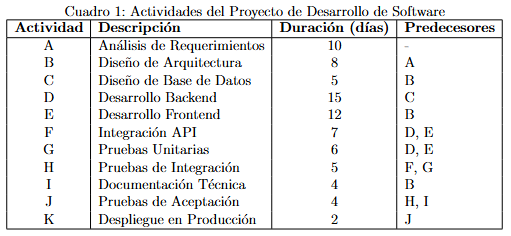

Representación de la Red

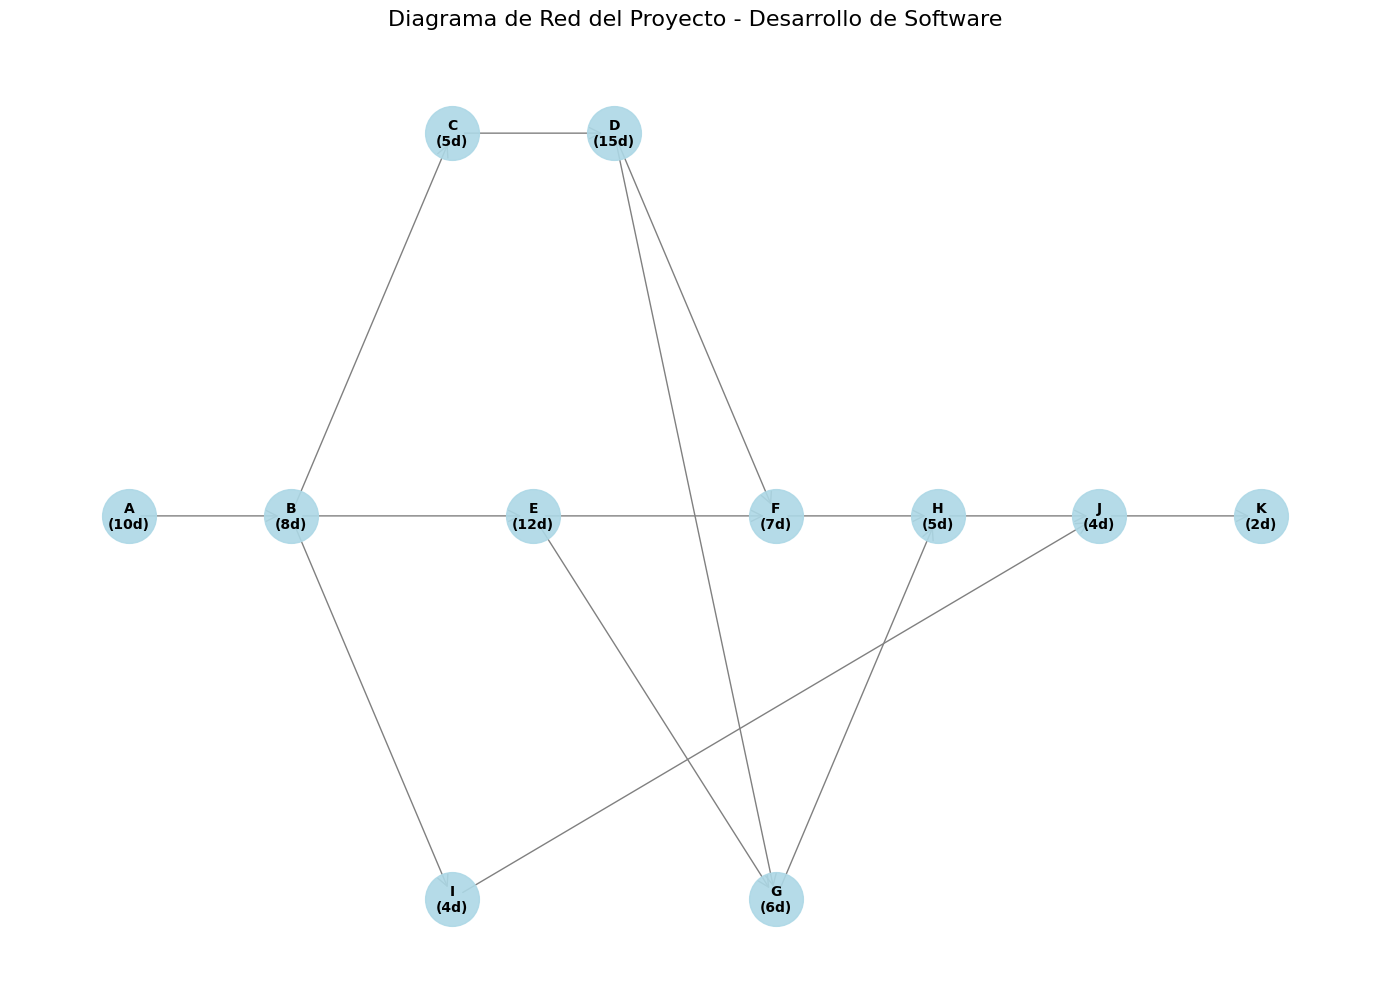

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear el grafo dirigido
G = nx.DiGraph()

# Definir las actividades y duraciones
actividades = {
    'A': {'descripcion': 'Análisis de Requerimientos', 'duracion': 10},
    'B': {'descripcion': 'Diseño de Arquitectura', 'duracion': 8},
    'C': {'descripcion': 'Diseño de Base de Datos', 'duracion': 5},
    'D': {'descripcion': 'Desarrollo Backend', 'duracion': 15},
    'E': {'descripcion': 'Desarrollo Frontend', 'duracion': 12},
    'F': {'descripcion': 'Integración API', 'duracion': 7},
    'G': {'descripcion': 'Pruebas Unitarias', 'duracion': 6},
    'H': {'descripcion': 'Pruebas de Integración', 'duracion': 5},
    'I': {'descripcion': 'Documentación Técnica', 'duracion': 4},
    'J': {'descripcion': 'Pruebas de Aceptación', 'duracion': 4},
    'K': {'descripcion': 'Despliegue en Producción', 'duracion': 2}
}

# Añadir nodos al grafo
for actividad, datos in actividades.items():
    G.add_node(actividad, descripcion=datos['descripcion'], duracion=datos['duracion'])

# Definir las dependencias (arcos)
dependencias = [
    ('A', 'B'), ('B', 'C'), ('B', 'E'), ('B', 'I'),
    ('C', 'D'), ('D', 'F'), ('D', 'G'), ('E', 'F'),
    ('E', 'G'), ('F', 'H'), ('G', 'H'), ('H', 'J'),
    ('I', 'J'), ('J', 'K')
]

# Añadir arcos al grafo
for predecesor, sucesor in dependencias:
    G.add_edge(predecesor, sucesor)

# Configurar el gráfico
plt.figure(figsize=(14, 10))

# Posicionamiento manual para mejor visualización
pos = {
    'A': (0, 0),
    'B': (2, 0),
    'C': (4, 1),
    'D': (6, 1),
    'E': (5, 0),
    'F': (8, 0),
    'G': (8, -1),
    'H': (10, 0),
    'I': (4, -1),
    'J': (12, 0),
    'K': (14, 0)
}

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_color='lightblue',
                      node_size=1500, alpha=0.9)

# Dibujar arcos
nx.draw_networkx_edges(G, pos, edge_color='gray',
                      arrows=True, arrowsize=20,
                      arrowstyle='->')

# Etiquetas de nodos con duración
labels = {node: f"{node}\n({G.nodes[node]['duracion']}d)" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

plt.title('Diagrama de Red del Proyecto - Desarrollo de Software', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

Variables y Fórmulas

\begin{align*}
ES_i &: \text{Tiempo de inicio más temprano de la actividad } i \\
EF_i &: \text{Tiempo de finalización más temprano de la actividad } i \\
LS_i &: \text{Tiempo de inicio más tardío de la actividad } i \\
LF_i &: \text{Tiempo de finalización más tardío de la actividad } i \\
D_i &: \text{Duración de la actividad } i \\
Holgura_i &: LS_i - ES_i = LF_i - EF_i
\end{align*}

Cálculo hacia adelante:
\begin{align*}
EF_i &= ES_i + D_i \\
ES_j &= \max\{EF_i \mid i \in P(j)\} \quad \text{donde } P(j) \text{ son predecesores de } j
\end{align*}

Cálculo hacia atrás:
\begin{align*}
LS_i &= LF_i - D_i \\
LF_i &= \min\{LS_j \mid j \in S(i)\} \quad \text{donde } S(i) \text{ son sucesores de } i
\end{align*}

#Análisis de Rutas

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import deque

# Definición de las actividades del proyecto de desarrollo de software
actividades = {
    'A': {'descripcion': 'Análisis de Requerimientos', 'duracion': 10, 'predecesores': []},
    'B': {'descripcion': 'Diseño de Arquitectura', 'duracion': 8, 'predecesores': ['A']},
    'C': {'descripcion': 'Diseño de Base de Datos', 'duracion': 5, 'predecesores': ['B']},
    'D': {'descripcion': 'Desarrollo Backend', 'duracion': 15, 'predecesores': ['C']},
    'E': {'descripcion': 'Desarrollo Frontend', 'duracion': 12, 'predecesores': ['B']},
    'F': {'descripcion': 'Integración API', 'duracion': 7, 'predecesores': ['D', 'E']},
    'G': {'descripcion': 'Pruebas Unitarias', 'duracion': 6, 'predecesores': ['D', 'E']},
    'H': {'descripcion': 'Pruebas de Integración', 'duracion': 5, 'predecesores': ['F', 'G']},
    'I': {'descripcion': 'Documentación Técnica', 'duracion': 4, 'predecesores': ['B']},
    'J': {'descripcion': 'Pruebas de Aceptación', 'duracion': 4, 'predecesores': ['H', 'I']},
    'K': {'descripcion': 'Despliegue en Producción', 'duracion': 2, 'predecesores': ['J']}
}

# Función para encontrar todas las rutas desde el inicio hasta el fin
def encontrar_todas_las_rutas(grafo):
    # Encontrar nodos iniciales (sin predecesores)
    nodos_iniciales = [nodo for nodo in grafo.nodes() if grafo.in_degree(nodo) == 0]
    # Encontrar nodos finales (sin sucesores)
    nodos_finales = [nodo for nodo in grafo.nodes() if grafo.out_degree(nodo) == 0]

    todas_las_rutas = []

    def dfs_rutas(nodo_actual, camino_actual):
        camino_actual.append(nodo_actual)

        if nodo_actual in nodos_finales:
            todas_las_rutas.append(camino_actual.copy())
        else:
            for sucesor in grafo.successors(nodo_actual):
                dfs_rutas(sucesor, camino_actual)

        camino_actual.pop()

    for inicio in nodos_iniciales:
        dfs_rutas(inicio, [])

    return todas_las_rutas

# Encontrar y mostrar todas las rutas
print("RUTAS DEL PROYECTO")
todas_rutas = encontrar_todas_las_rutas(G)

rutas_con_duracion = []
for i, ruta in enumerate(todas_rutas, 1):
    duracion_total = sum(actividades[nodo]['duracion'] for nodo in ruta)
    rutas_con_duracion.append((ruta, duracion_total))
    print(f"Ruta {i}: {' → '.join(ruta)}")
    print(f"  Duración: {duracion_total} días")
    print(f"  Actividades: {len(ruta)}")
    print()

# Identificar la ruta crítica (mayor duración)
ruta_critica = max(rutas_con_duracion, key=lambda x: x[1])
print("RUTA CRÍTICA IDENTIFICADA")
print(f"Ruta: {' → '.join(ruta_critica[0])}")
print(f"Duración total: {ruta_critica[1]} días")
print()

=== TODAS LAS RUTAS DEL PROYECTO ===
Ruta 1: A → B → C → D → F → H → J → K
  Duración: 56 días
  Actividades: 8

Ruta 2: A → B → C → D → G → H → J → K
  Duración: 55 días
  Actividades: 8

Ruta 3: A → B → E → F → H → J → K
  Duración: 48 días
  Actividades: 7

Ruta 4: A → B → E → G → H → J → K
  Duración: 47 días
  Actividades: 7

Ruta 5: A → B → I → J → K
  Duración: 28 días
  Actividades: 5

=== RUTA CRÍTICA IDENTIFICADA ===
Ruta: A → B → C → D → F → H → J → K
Duración total: 56 días



#Resultados del Análisis CPM

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import deque

# Definición de las actividades del proyecto de desarrollo de software
actividades = {
    'A': {'descripcion': 'Análisis de Requerimientos', 'duracion': 10, 'predecesores': []},
    'B': {'descripcion': 'Diseño de Arquitectura', 'duracion': 8, 'predecesores': ['A']},
    'C': {'descripcion': 'Diseño de Base de Datos', 'duracion': 5, 'predecesores': ['B']},
    'D': {'descripcion': 'Desarrollo Backend', 'duracion': 15, 'predecesores': ['C']},
    'E': {'descripcion': 'Desarrollo Frontend', 'duracion': 12, 'predecesores': ['B']},
    'F': {'descripcion': 'Integración API', 'duracion': 7, 'predecesores': ['D', 'E']},
    'G': {'descripcion': 'Pruebas Unitarias', 'duracion': 6, 'predecesores': ['D', 'E']},
    'H': {'descripcion': 'Pruebas de Integración', 'duracion': 5, 'predecesores': ['F', 'G']},
    'I': {'descripcion': 'Documentación Técnica', 'duracion': 4, 'predecesores': ['B']},
    'J': {'descripcion': 'Pruebas de Aceptación', 'duracion': 4, 'predecesores': ['H', 'I']},
    'K': {'descripcion': 'Despliegue en Producción', 'duracion': 2, 'predecesores': ['J']}
}

# Calcular tiempos tempranos (Forward Pass)
def forward_pass(G):
    tiempos_tempranos = {nodo: 0 for nodo in G.nodes()}

    # Orden topológico
    orden_topologico = list(nx.topological_sort(G))

    for nodo in orden_topologico:
        max_tiempo = 0
        for predecesor in G.predecessors(nodo):
            tiempo_predecesor = tiempos_tempranos[predecesor] + G.nodes[predecesor]['duracion']
            if tiempo_predecesor > max_tiempo:
                max_tiempo = tiempo_predecesor
        tiempos_tempranos[nodo] = max_tiempo

    return tiempos_tempranos

# %%
# Calcular tiempos tardíos (Backward Pass)
def backward_pass(G, duracion_proyecto):
    tiempos_tardios = {nodo: duracion_proyecto for nodo in G.nodes()}

    # Orden topológico inverso
    orden_topologico_inverso = list(reversed(list(nx.topological_sort(G))))

    for nodo in orden_topologico_inverso:
        min_tiempo = duracion_proyecto
        for sucesor in G.successors(nodo):
            tiempo_sucesor = tiempos_tardios[sucesor] - G.nodes[nodo]['duracion']
            if tiempo_sucesor < min_tiempo:
                min_tiempo = tiempo_sucesor
        if min_tiempo == duracion_proyecto:  # Para el nodo final
            min_tiempo = duracion_proyecto - G.nodes[nodo]['duracion']
        tiempos_tardios[nodo] = min_tiempo

    return tiempos_tardios

# Ejecutar cálculos CPM
tiempos_tempranos = forward_pass(G)
duracion_proyecto = max(tiempos_tempranos[nodo] + G.nodes[nodo]['duracion'] for nodo in G.nodes())
tiempos_tardios = backward_pass(G, duracion_proyecto)

print(f"Duración total del proyecto: {duracion_proyecto} días")

# Calcular holguras y identificar ruta crítica
resultados = []
for nodo in G.nodes():
    inicio_temprano = tiempos_tempranos[nodo]
    fin_temprano = inicio_temprano + G.nodes[nodo]['duracion']
    fin_tardio = tiempos_tardios[nodo] + G.nodes[nodo]['duracion']
    inicio_tardio = tiempos_tardios[nodo]
    holgura = inicio_tardio - inicio_temprano

    resultados.append({
        'Actividad': nodo,
        'Descripción': G.nodes[nodo]['descripcion'],
        'Duración': G.nodes[nodo]['duracion'],
        'Inicio Temprano': inicio_temprano,
        'Fin Temprano': fin_temprano,
        'Inicio Tardío': inicio_tardio,
        'Fin Tardío': fin_tardio,
        'Holgura': holgura,
        'Crítica': 'Sí' if holgura == 0 else 'No'
    })

# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados.to_string(index=False))

# Identificar actividades críticas
actividades_criticas = [nodo for nodo in G.nodes()
                        if (tiempos_tardios[nodo] - tiempos_tempranos[nodo]) == 0]
print(f"\nActividades críticas: {', '.join(actividades_criticas)}")


Duración total del proyecto: 56 días
Actividad                Descripción  Duración  Inicio Temprano  Fin Temprano  Inicio Tardío  Fin Tardío  Holgura Crítica
        A Análisis de Requerimientos        10                0            10              0          10        0      Sí
        B     Diseño de Arquitectura         8               10            18             10          18        0      Sí
        C    Diseño de Base de Datos         5               18            23             18          23        0      Sí
        D         Desarrollo Backend        15               23            38             23          38        0      Sí
        E        Desarrollo Frontend        12               18            30             26          38        8      No
        F            Integración API         7               38            45             38          45        0      Sí
        G          Pruebas Unitarias         6               38            44             39          45     

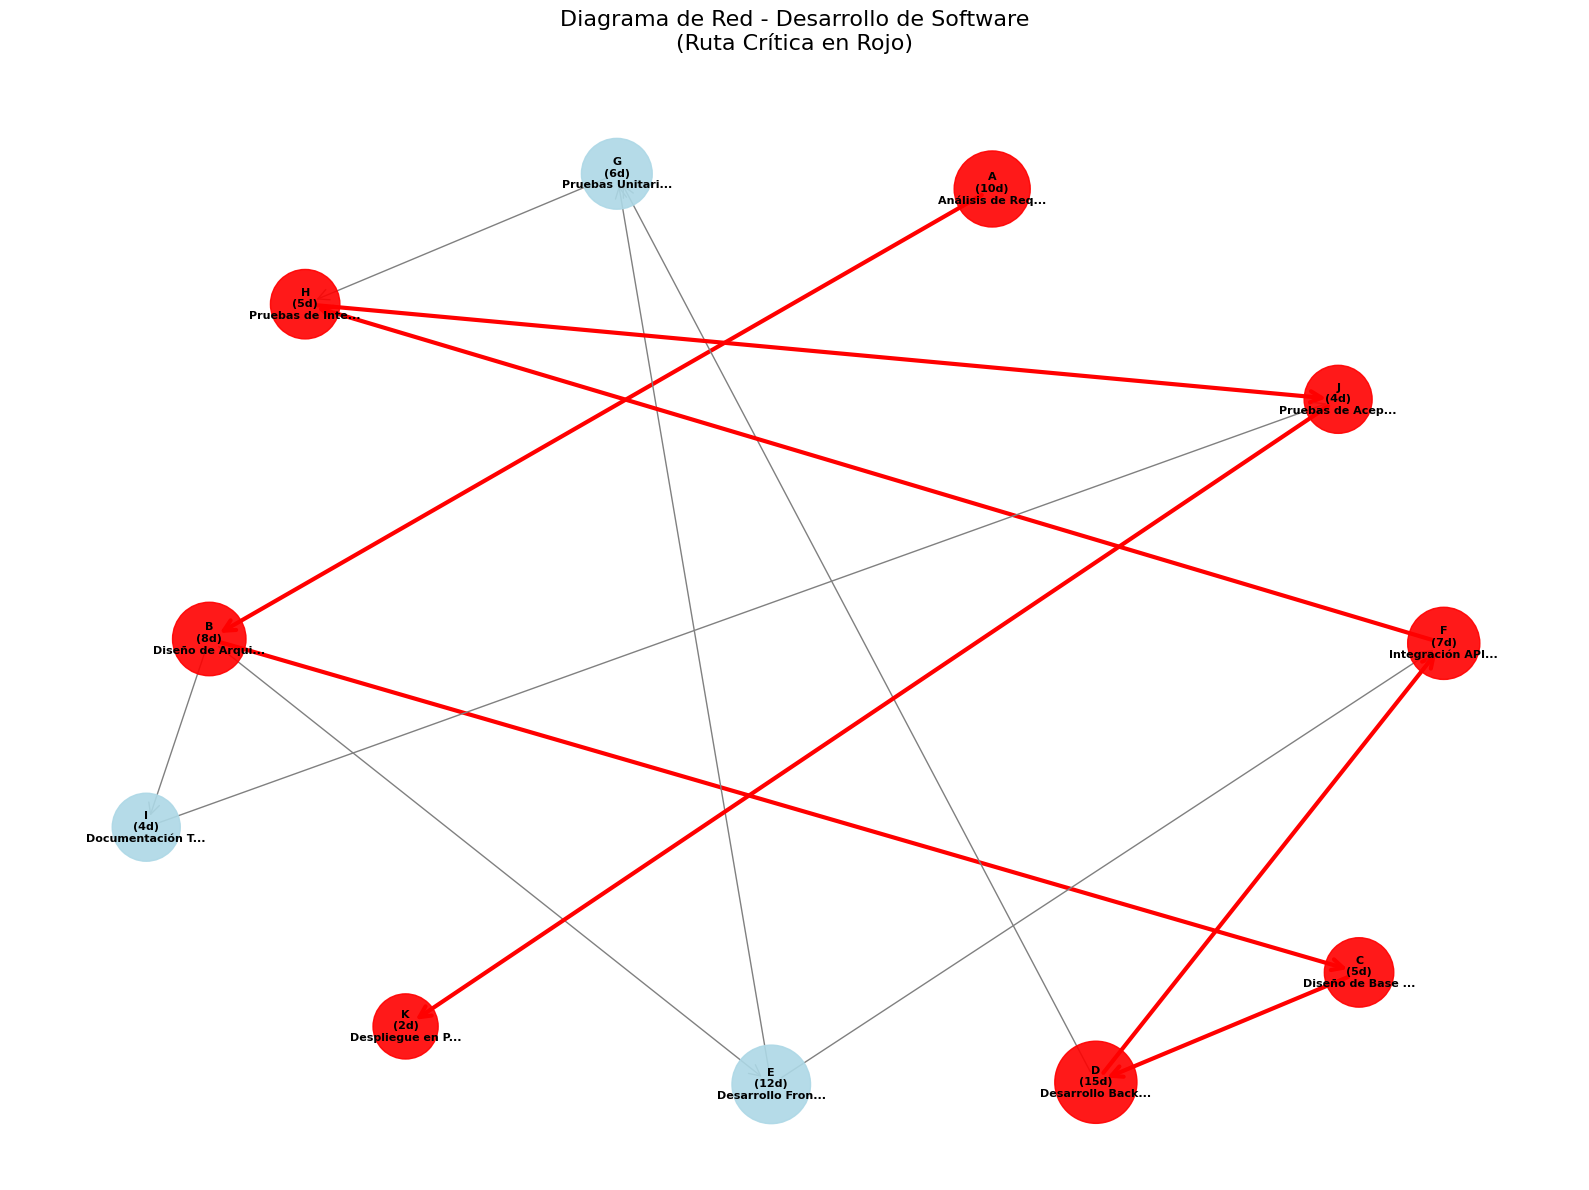

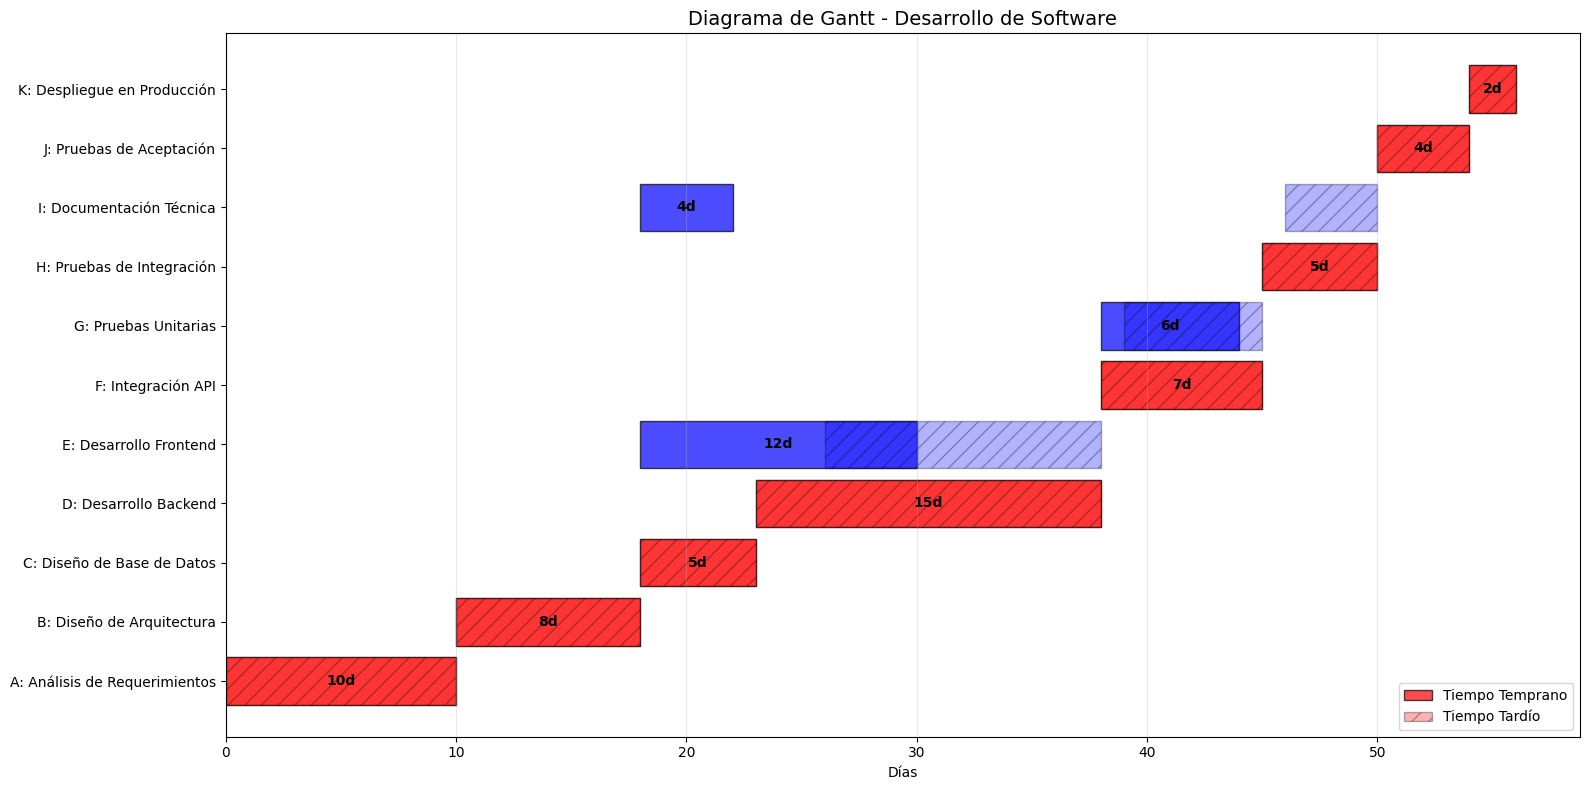

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import deque

# Definición de las actividades del proyecto de desarrollo de software
actividades = {
    'A': {'descripcion': 'Análisis de Requerimientos', 'duracion': 10, 'predecesores': []},
    'B': {'descripcion': 'Diseño de Arquitectura', 'duracion': 8, 'predecesores': ['A']},
    'C': {'descripcion': 'Diseño de Base de Datos', 'duracion': 5, 'predecesores': ['B']},
    'D': {'descripcion': 'Desarrollo Backend', 'duracion': 15, 'predecesores': ['C']},
    'E': {'descripcion': 'Desarrollo Frontend', 'duracion': 12, 'predecesores': ['B']},
    'F': {'descripcion': 'Integración API', 'duracion': 7, 'predecesores': ['D', 'E']},
    'G': {'descripcion': 'Pruebas Unitarias', 'duracion': 6, 'predecesores': ['D', 'E']},
    'H': {'descripcion': 'Pruebas de Integración', 'duracion': 5, 'predecesores': ['F', 'G']},
    'I': {'descripcion': 'Documentación Técnica', 'duracion': 4, 'predecesores': ['B']},
    'J': {'descripcion': 'Pruebas de Aceptación', 'duracion': 4, 'predecesores': ['H', 'I']},
    'K': {'descripcion': 'Despliegue en Producción', 'duracion': 2, 'predecesores': ['J']}
}

# Crear el grafo del proyecto
G = nx.DiGraph()

# Agregar nodos (actividades) con sus duraciones
for actividad, datos in actividades.items():
    G.add_node(actividad, duracion=datos['duracion'], descripcion=datos['descripcion'])

# Agregar arcos (dependencias)
for actividad, datos in actividades.items():
    for predecesor in datos['predecesores']:
        G.add_edge(predecesor, actividad)

# Visualizar el grafo del proyecto
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=3, iterations=50)

# Dibujar nodos
node_colors = ['red' if act in actividades_criticas else 'lightblue' for act in G.nodes()]
node_sizes = [2000 + actividades[act]['duracion'] * 100 for act in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)

# Dibujar arcos
edge_colors = ['red' if (u in actividades_criticas and v in actividades_criticas)
               else 'gray' for u, v in G.edges()]
edge_widths = [3 if (u in actividades_criticas and v in actividades_criticas)
               else 1 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20,
                      edge_color=edge_colors, width=edge_widths)

# Etiquetas de nodos
labels = {nodo: f"{nodo}\n({actividades[nodo]['duracion']}d)\n{actividades[nodo]['descripcion'][:15]}..."
          for nodo in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')

# Título y mostrar
plt.title("Diagrama de Red - Desarrollo de Software\n(Ruta Crítica en Rojo)", size=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Diagrama de Gantt mejorado
fig, ax1 = plt.subplots(1, 1, figsize=(16, 8))

# Diagrama de Gantt principal
y_pos = range(len(df_resultados))
activities_labels = [f"{row['Actividad']}: {row['Descripción']}" for _, row in df_resultados.iterrows()]

for i, row in df_resultados.iterrows():
    color = 'red' if row['Crítica'] == 'Sí' else 'blue'

    # Barra de tiempo temprano
    ax1.barh(i, row['Duración'], left=row['Inicio Temprano'],
            color=color, alpha=0.7, edgecolor='black')

    # Barra de tiempo tardío (transparente)
    ax1.barh(i, row['Duración'], left=row['Inicio Tardío'],
            color=color, alpha=0.3, edgecolor='black', hatch='//')

    # Texto con duración
    ax1.text(row['Inicio Temprano'] + row['Duración']/2, i,
            f"{row['Duración']}d", va='center', ha='center', fontweight='bold')

ax1.set_yticks(y_pos)
ax1.set_yticklabels(activities_labels)
ax1.set_xlabel('Días')
ax1.set_title('Diagrama de Gantt - Desarrollo de Software', size=14)
ax1.legend(['Tiempo Temprano', 'Tiempo Tardío'], loc='lower right')
ax1.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

El análisis de ruta crítica identifica que el proyecto de desarrollo de software tendrá una duración mínima de 56 días. Las actividades A, B, C, D, F, H, J y K forman la ruta crítica y requieren supervisión estrecha. Las actividades E, G e I tienen holgura que puede utilizarse para optimizar recursos y gestionar contingencias.